## Introduction

First, you need to obtain and preprocess the data for the segmentation task
The data is provided by the medical segmentation decathlon challenge(http://medicaldecathlon.com/) <br />
You can directly download the full body cts and segmentation maps from: <br />
https://drive.google.com/file/d/1I1LR7XjyEZ-VBQ-Xruh31V7xExMjlVvi/view?usp=sharing

(Data License: CC-BY-SA 4.0, https://creativecommons.org/licenses/by-sa/4.0/)

## Imports
Import the necessary libraries**

In [1]:
from pathlib import Path
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Inspection
Define the paths to images and labels**

In [2]:
images_path = Path("../Data/lung_tumor_segmentation/imagesTr") 
labels_path = Path("../Data/lung_tumor_segmentation/labelsTr") 

**Load a sample NIfTI and its corresponding label mask**<br />

In [3]:
def change_image_path_to_label(path):
    parts = list(path.parts)
    parts[parts.index("imagesTr")] = "labelsTr"
    return Path(*parts)


In [4]:
sample_image_path = list(images_path.glob("lung*"))[0]
sample_label_path = change_image_path_to_label(sample_image_path)
sample_image_path, sample_label_path

(PosixPath('../Data/lung_tumor_segmentation/imagesTr/lung_009.nii.gz'),
 PosixPath('../Data/lung_tumor_segmentation/labelsTr/lung_009.nii.gz'))

In [5]:
image = nib.load(sample_image_path)
label = nib.load(sample_label_path)

image_data = image.get_fdata()
label_data = label.get_fdata()

In [6]:
image_data.shape, label_data.shape

((512, 512, 301), (512, 512, 301))

**Find out the orientation**

In [7]:
nib.aff2axcodes(image.affine), nib.aff2axcodes(label.affine)

(('L', 'A', 'S'), ('L', 'A', 'S'))

**Inspect the loaded data with overlaid Ground Truth tumor segmentation**<br />

In [8]:
from celluloid import Camera
from IPython.display import HTML

In [23]:
fig = plt.figure()
camera = Camera(fig)

for i in range(image_data.shape[2]):
    plt.imshow(image_data[:, :, i], cmap="gray")
    mask_ = np.ma.masked_where(label_data[:, :, i] == 0, label_data[:, :, i])
    plt.imshow(mask_, alpha=0.4)
    camera.snap()

animation = camera.animate()

In [ ]:
HTML(animation.to_html5_video())

## Preprocessing
**Task: Please perform the following preprocessing steps:**

1. CT images have a fixed range from -1000 to 3071. **Thus you could normalize by dividing by 3071** <br /> You don't need to compute mean and standard deviation for this task
2. As we want to focus on lung tumors, we can crop away parts of the lower abdomen to reduce the complexity and help the network learn. As an example, **you might skip the first 30 slices (from lower abdomen to the neck)** (last axis)
3. As we want to tackle this task on a slice level (2D) and not on a subject level (3D) to reduce the computational cost **you should store the preprocessed data as 2d files**, because reading a single slice is much faster than loading the complete NIfTI file.
4. Resize the single slices and masks to (256, 256) (when resizing the mask, pass interpolation=cv2.INTER_NEAREST to the resize function to apply nearest neighbour interpolation)

Loop over all_files and apply the preprocessing steps. <br />

Additionally, please make sure that all scans have the same orientation

In the preprocessing loop, you need to create a directory for each subject containg the ct and label slices with identical names. <br />
E.g:
* 0/data/0.npy
* 0/masks/0.npy

Store the last 6 subjects as validation data

PS: Feel free to try the lung window!

In [11]:
all_files = list(images_path.glob("lung_*"))  # Get all subjects
len(all_files)

63

In [12]:
len(all_files[10:])

53

In [16]:
save_root = Path("../Data/lung_tumor_segmentation/processed")
strip_val = 0
all_files_stripped = all_files[strip_val:]

for counter, mri_data_path in enumerate(tqdm(all_files_stripped)):
    path_to_label = change_image_path_to_label(mri_data_path)

    mri_data = nib.load(mri_data_path).get_fdata()
    label_data = nib.load(path_to_label).get_fdata()

    mri_data = mri_data[:, :, 30:] / 3071
    label_data = label_data[:, :, 30:]

    if counter < 57:
        current_path = save_root/"train"/str(counter)
    else:
        current_path = save_root/"val"/str(counter)
        

    for i in range(mri_data.shape[-1]):
        slice = mri_data[:,:,i]
        mask = label_data[:, :, i]

        slice_resized = cv2.resize(slice, (256, 256))
        mask_resized = cv2.resize(mask, (256, 256), interpolation = cv2.INTER_NEAREST)

        slice_path = current_path/"data"
        mask_path = current_path/"masks"
        
        slice_path.mkdir(parents=True, exist_ok=True)
        mask_path.mkdir(parents=True, exist_ok=True)
        
        np.save(slice_path/str(i), slice_resized)
        np.save(mask_path/str(i), mask_resized)

100%|██████████| 63/63 [08:34<00:00,  8.17s/it]


## Validate preprocessed data
**Take a look at your stored files and inspect if everything worked as expected**

In [21]:
path = Path("../Data/lung_tumor_segmentation/processed/train/0")

file = "250.npy"

slice = np.load(path/"data"/file)
mask = np.load(path/"masks"/file)

slice.shape, mask.shape

((256, 256), (256, 256))

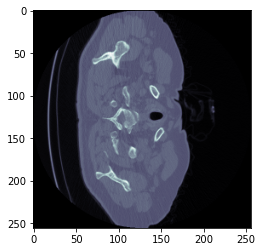

In [22]:
plt.imshow(slice, cmap="bone")
mask_ = np.ma.masked_where(mask==0, mask)
plt.imshow(mask_, alpha=0.7)